In [53]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #

import xtrack as xt
import xobjects as xo
import xpart as xp
import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 



In [54]:
line = xt.Line.from_json('elena.json')
particle_ref = line.particle_ref
line.build_tracker()
twiss = line.twiss()

beta0=particle_ref.beta0
gamma0 = particle_ref.gamma0
circumference = twiss.circumference #m

clight=constants.speed_of_light
T_per_turn = circumference/(clight*beta0)

ec_index=698

beta_x  = twiss.betx[ec_index]
beta_y  = twiss.bety[ec_index]
alpha_x = twiss.alfx[ec_index]
alpha_y = twiss.alfy[ec_index]
gamma_x = twiss.gamx[ec_index]
gamma_y = twiss.gamy[ec_index]

Dx  =  twiss.dx[ec_index]
Dpx =  twiss.dpx[ec_index]

Dy  =  twiss.dy[ec_index]
Dpy =  twiss.dpy[ec_index]


Loading line from dict:   0%|          | 0/1336 [00:00<?, ?it/s]

Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 19849.28it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [55]:
twiss.keys()
twiss.bets0

-469.32883416451523

In [56]:
num_particles=int(1e4)

beta_x_sem = 7.6 #m
beta_y_sem = 1.3 #m

#bunch_length=75*1e-9*clight #https://cds.cern.ch/record/2845870/files/document.pdf
bunch_intensity=5e7
sigma_dp = 1e-3
sigma_z=-twiss.bets0*sigma_dp

print('sigma_z',sigma_z)

# eps_x= 2.25*1e-6-(D_x*sigma_dp)**2/beta_x_sem
# eps_x= 2.25*1e-6

gemitt_x = 2.5*1e-6
gemitt_y = 2.5*1e-6
nemitt_x = gemitt_x*beta0*gamma0
nemitt_y = gemitt_y*beta0*gamma0

particles_old = xp.generate_matched_gaussian_bunch(
        num_particles=num_particles,
        # total_intensity_particles=bunch_intensity,
        nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=sigma_z,
        particle_ref=particle_ref,
        line=line,        
        )

#particles_old.delta = np.random.normal(0, sigma_dp, num_particles)
particles_old.zeta = np.random.uniform(-circumference/2, circumference/2, num_particles)


action_x = ((particles_old.x-Dx*particles_old.delta)**2/beta_x + beta_x*particles_old.px**2)
geo_emittance_x=np.mean(action_x)/2

print('emittance:',geo_emittance_x)

action_x2 = ((particles_old.x)**2/beta_x + beta_x*particles_old.px**2)
geo_emittance_x2=np.mean(action_x2)/2

print('emittance2:',geo_emittance_x2)


sigma_z 0.46932883416451526
emittance: 5.465371786432117e-06
emittance2: 5.817659773981115e-06


In [57]:
np.std(particles_old.delta)

LinkedArrayCpu(0.00100613)

In [58]:
data=np.load('H_angles/angles.npz')

n_steps=data['n_steps']
num_samples=data['num_samples']
delay_list=data['delay_list']
repeated_delay=data['repeated_delay']


data = np.load('results/optimize_angles.npz')

# Access the shifted_angles and filter_horizontal arrays
shifted_angles = data['shifted_angles']
filter_horizontal = data['filter_horizontal']


sorted_unique_values = np.sort(np.unique(repeated_delay))
second_min_nonzero_value = sorted_unique_values[1]
simulation_time=(np.max(repeated_delay)-second_min_nonzero_value)/1000

# angle_list=np.linspace(-40e-3,40e-3,50)

final_emittance_x=[]
final_emittance_x_normalised=[]
sigma_x_list=[]

final_emittance_y=[]
final_emittance_y_normalised=[]
sigma_y_list=[]

# simulation parameters: simulate 10 s of cooling, and take data once every 10 ms
max_time_s = 715*1e-3
int_time_s = 0.01

# compute length of simulation, as well as sample interval, in turns
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)


# angles_list=[0]

for angle in tqdm(shifted_angles):

        print('angle:',angle)

        line = xt.Line.from_json('elena.json')
        particle_ref = line.particle_ref
        line.build_tracker()
        twiss = line.twiss()

        beta0=particle_ref.beta0
        gamma0 = particle_ref.gamma0
        circumference = twiss.circumference #m

        clight=constants.speed_of_light
        T_per_turn = circumference/(clight*beta0)

       

        # electron cooler parameters
        current = 0.34*1e-3 # A current
        cooler_length = 1 # m cooler length
        radius_e_beam = 14*1e-3 #m radius of the electron beam
        temp_perp = 100e-3 # <E> [eV] = kb*T
        temp_long =  1e-3 # <E> [eV]
        magnetic_field = 0.010 # 100 Gauss in ELENA

        electron_cooler = xt.ElectronCooler(
                length=cooler_length,
                radius_e_beam=radius_e_beam,
                current=current,
                temp_perp=temp_perp,
                temp_long=temp_long,
                magnetic_field=magnetic_field, 
                magnetic_field_ratio=1e-3,
                offset_px=angle*1e-3,
                space_charge=1)


        # simulation parameters: simulate 1 s of cooling, and take data once every 10 ms
        max_time_s = 715*1e-3
        int_time_s = 0.01

        # compute length of simulation, as well as sample interval, in turns
        num_turns = int(max_time_s/T_per_turn)
        save_interval = int(int_time_s/T_per_turn)

        # create a monitor object, to reduce holded data
        monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                n_repetitions=int(num_turns/save_interval),
                                repetition_period=save_interval,
                                num_particles=num_particles)

        line.discard_tracker()

        
        line.insert_element('ecooler', element=electron_cooler, index=ec_index) #this way monitor comes before the cooler
        line.insert_element('monitor', element=monitor, index=ec_index)


        #print(line.element_names[ec_index])
        #print(line.element_names[ec_index+1])

        context = xo.ContextCpu(omp_num_threads=6)
        # context = xo.ContextCupy()
        # context = xo.ContextPyopencl()
        line.build_tracker(_context=context)
        line.optimize_for_tracking()

        line_table = line.get_table()
        element_mask = np.where(line_table['element_type']=='Cavity')[0]
        for i in element_mask:
                cav_name = line_table['name'][i]
                line.elements[i].voltage = 0
                line.elements[i].frequency = 0
                print('All cavities switched off.')

        particles=particles_old.copy()

        # just track all particles, and keep turn-by-turn data (memory expensive!)
        line.track(particles, num_turns=num_turns,
                turn_by_turn_monitor=False,with_progress=True)

        # extract relevant values
        x = monitor.x[:,:,0]
        px = monitor.px[:,:,0]
        y = monitor.y[:,:,0]
        py = monitor.py[:,:,0]
        delta = monitor.delta[:,:,0]
        zeta = monitor.zeta[:,:,0]
        time = monitor.at_turn[:, 0, 0] * T_per_turn

        # compute actions. for x, remove the dp/p contribution:
        action_x = ((x-Dx*delta)**2/beta_x + beta_x*px**2)
        action_y = (y**2/beta_y + beta_y*py**2)

        action_x = (gamma_x*(x-Dx*delta)**2 
                + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta) 
                + beta_x*(px-Dpx*delta)**2)
        action_y = (gamma_y*(y-Dy*delta)**2
                + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta) 
                + beta_y*(py-Dpy*delta)**2)
        

        action_x2 = (gamma_x*(x)**2 
                + 2*alpha_x*(x)*(px) 
                + beta_x*(px)**2)
        action_y2= (gamma_y*(y)**2
                + 2*alpha_y*(y)*(py) 
                + beta_y*(py)**2)

        norm_emittance_x=np.mean(action_x,axis=1)/2*gamma0*beta0
        norm_emittance_y=np.mean(action_y,axis=1)/2*gamma0*beta0

        geo_emittance_x=np.mean(action_x,axis=1)/2
        geo_emittance_y=np.mean(action_y,axis=1)/2

        geo_emittance_x2=np.mean(action_x2,axis=1)/2
        geo_emittance_y2=np.mean(action_y2,axis=1)/2


        np.savez(f'results_lattice/optimize_angles/angle_{angle}.npz',
                
                geo_emittance_x2=geo_emittance_x2,
                geo_emittance_y2=geo_emittance_y2,
                
                geo_emittance_x=geo_emittance_x,
                geo_emittance_y=geo_emittance_y,
                norm_emittance_x=norm_emittance_x,
                norm_emittance_y=norm_emittance_y,
                x=x,  
                y=y,  
                px=px,  
                py=py,
                delta=delta,
                zeta=zeta,
                time=time)  

/tmp/pkruyt/ipykernel_392860/1297045539.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_turns = int(max_time_s/T_per_turn)
/tmp/pkruyt/ipykernel_392860/1297045539.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  save_interval = int(int_time_s/T_per_turn)
  0%|          | 0/51 [00:00<?, ?it/s]

angle: -0.7602040816326531


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 15923.68it/s]

Done loading line from dict.           


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


/tmp/pkruyt/ipykernel_392860/1297045539.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_turns = int(max_time_s/T_per_turn)
/tmp/pkruyt/ipykernel_392860/1297045539.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  save_interval = int(int_time_s/T_per_turn)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


  2%|▏         | 1/51 [07:27<6:13:14, 447.90s/it]

angle: -0.8010204081632654


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 23145.67it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


  4%|▍         | 2/51 [15:11<6:13:15, 457.05s/it]

angle: -0.8418367346938775


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 20888.58it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


  6%|▌         | 3/51 [22:38<6:01:55, 452.41s/it]

angle: -0.9234693877551021


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 27082.91it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


  8%|▊         | 4/51 [29:34<5:43:06, 438.01s/it]

angle: -0.9642857142857143


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 26956.93it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 10%|▉         | 5/51 [36:32<5:30:19, 430.85s/it]

angle: -1.0051020408163265


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 27383.88it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 12%|█▏        | 6/51 [43:28<5:19:17, 425.73s/it]

angle: -1.0459183673469388


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 27602.40it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 14%|█▎        | 7/51 [50:26<5:10:29, 423.40s/it]

angle: -1.086734693877551


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28887.46it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 16%|█▌        | 8/51 [57:23<5:01:49, 421.16s/it]

angle: -1.1275510204081631


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 30490.42it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 18%|█▊        | 9/51 [1:04:21<4:54:14, 420.35s/it]

angle: -1.1683673469387754


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 30735.25it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 20%|█▉        | 10/51 [1:11:18<4:46:28, 419.24s/it]

angle: -1.2091836734693877


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 29713.40it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 22%|██▏       | 11/51 [1:18:17<4:39:24, 419.12s/it]

angle: -0.7193877551020409


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 30576.60it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 24%|██▎       | 12/51 [1:25:13<4:31:55, 418.35s/it]

angle: -0.6785714285714286


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 30982.17it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 25%|██▌       | 13/51 [1:32:11<4:24:47, 418.09s/it]

angle: -0.6377551020408164


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 31020.93it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 27%|██▋       | 14/51 [1:39:07<4:17:33, 417.65s/it]

angle: -0.5969387755102041


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 24529.17it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 29%|██▉       | 15/51 [1:46:06<4:10:41, 417.82s/it]

angle: -0.5561224489795918


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 29919.48it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 31%|███▏      | 16/51 [1:53:01<4:03:22, 417.20s/it]

angle: -0.5153061224489797


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 31123.62it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 33%|███▎      | 17/51 [1:59:59<3:56:28, 417.29s/it]

angle: -0.4744897959183674


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 26418.32it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 35%|███▌      | 18/51 [2:06:57<3:49:37, 417.50s/it]

angle: -0.4336734693877552


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 32015.39it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 37%|███▋      | 19/51 [2:13:53<3:42:22, 416.95s/it]

angle: -0.3928571428571429


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 26973.02it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 39%|███▉      | 20/51 [2:20:51<3:35:35, 417.28s/it]

angle: -0.3520408163265307


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 29710.56it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 41%|████      | 21/51 [2:27:47<3:28:27, 416.90s/it]

angle: -0.31122448979591844


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28589.31it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 43%|████▎     | 22/51 [2:34:44<3:21:37, 417.15s/it]

angle: -0.27040816326530615


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 22107.60it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 45%|████▌     | 23/51 [2:41:42<3:14:44, 417.32s/it]

angle: -0.22959183673469385


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 29988.01it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 47%|████▋     | 24/51 [2:48:40<3:07:55, 417.63s/it]

angle: -0.1887755102040818


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 24803.65it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 49%|████▉     | 25/51 [2:55:39<3:01:05, 417.90s/it]

angle: -0.1479591836734695


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 26723.21it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 51%|█████     | 26/51 [3:02:37<2:54:07, 417.91s/it]

angle: -0.1071428571428572


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28820.16it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 53%|█████▎    | 27/51 [3:09:34<2:47:03, 417.63s/it]

angle: -0.06632653061224492


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 30664.78it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 55%|█████▍    | 28/51 [3:16:33<2:40:16, 418.09s/it]

angle: -0.025510204081632848


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 23568.16it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 57%|█████▋    | 29/51 [3:23:30<2:33:09, 417.69s/it]

angle: 0.015306122448979442


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 31950.59it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 59%|█████▉    | 30/51 [3:30:29<2:26:17, 417.98s/it]

angle: 0.05612244897959173


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28547.07it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 61%|██████    | 31/51 [3:37:26<2:19:17, 417.85s/it]

angle: 0.09693877551020402


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 29525.06it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 63%|██████▎   | 32/51 [3:44:23<2:12:15, 417.64s/it]

angle: 0.1377551020408163


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 30083.97it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 65%|██████▍   | 33/51 [3:51:20<2:05:13, 417.42s/it]

angle: 0.17857142857142838


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28630.06it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 67%|██████▋   | 34/51 [3:58:18<1:58:16, 417.42s/it]

angle: 0.21938775510204067


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 31099.44it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 69%|██████▊   | 35/51 [4:05:15<1:51:17, 417.32s/it]

angle: 0.26020408163265296


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 23196.26it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 71%|███████   | 36/51 [4:12:12<1:44:20, 417.36s/it]

angle: 0.30102040816326525


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 24628.68it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 73%|███████▎  | 37/51 [4:19:09<1:37:23, 417.37s/it]

angle: 0.3418367346938773


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 31962.80it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 75%|███████▍  | 38/51 [4:26:07<1:30:26, 417.45s/it]

angle: 0.3826530612244896


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 30240.80it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 76%|███████▋  | 39/51 [4:33:04<1:23:27, 417.33s/it]

angle: 0.4234693877551019


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28518.01it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 78%|███████▊  | 40/51 [4:40:03<1:16:34, 417.69s/it]

angle: 0.4642857142857142


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 23871.48it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 80%|████████  | 41/51 [4:46:58<1:09:31, 417.12s/it]

angle: 0.5029999999999999


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 27769.96it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 82%|████████▏ | 42/51 [4:53:54<1:02:29, 416.62s/it]

angle: 0.504


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 24089.44it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 84%|████████▍ | 43/51 [5:00:51<55:33, 416.73s/it]  

angle: 0.5049999999999999


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 29183.85it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 86%|████████▋ | 44/51 [5:07:48<48:38, 416.98s/it]

angle: 0.5051020408163265


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28663.31it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 88%|████████▊ | 45/51 [5:14:46<41:42, 417.06s/it]

angle: 0.506


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 30370.12it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 90%|█████████ | 46/51 [5:21:41<34:41, 416.38s/it]

angle: 0.5459183673469385


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28230.24it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 92%|█████████▏| 47/51 [5:28:38<27:46, 416.75s/it]

angle: 0.5867346938775508


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28491.62it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 94%|█████████▍| 48/51 [5:35:35<20:50, 416.87s/it]

angle: 0.6683673469387754


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28855.78it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 96%|█████████▌| 49/51 [5:42:32<13:53, 416.84s/it]

angle: 0.7091836734693877


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28809.94it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


 98%|█████████▊| 50/51 [5:49:30<06:57, 417.24s/it]

angle: 0.75


Loading line from dict: 100%|██████████| 1336/1336 [00:00<00:00, 28498.29it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
All cavities switched off.


100%|██████████| 51/51 [5:56:28<00:00, 419.38s/it]


In [59]:
print('geo_emittance_x',geo_emittance_x[0])
print('geo_emittance_y',geo_emittance_y[0])

geo_emittance_x 2.492922462697885e-06
geo_emittance_y 2.5137426793903273e-06


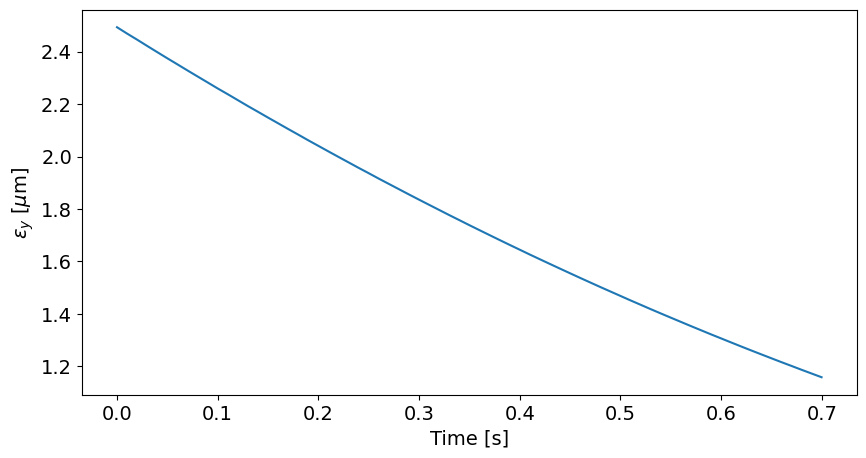

In [60]:
# plot some overall values
plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 14})  # set the default fontsize to 14
plt.plot(time, geo_emittance_x * 1e6)
plt.xlabel('Time [s]')
plt.ylabel('$\\epsilon_y$ [$\\mu$m]')
plt.show()